### Python and Just-in-Time Compilation:

This is a quick lecture to take a look at the ways to improve the performance of interpreted code. We have been working with compiled code with OpenMP in C, so now let's jump back to interpreted code in Python.

* _Compilation_ is the process of generating machine code that can be run directly on a processor from source code written in a programming language.

* _Interpreters_ are programs that directly execute instructions written in a programming language without compilation.

There is a lot of gray area and confusion and reality will often blend these concepts. Let's consider the Java landscape. Java source code is _compiled_ into a intermediate representation (Java byte code) that run through some combination of:
  * a Java _interpreter_ that translates Java byte code to machine instructions
  * a just-in-time (JIT) compiler that translates byte code into machine code as the program executes
  
Java ends up being a compiled language from a programmer's perspective. The interpreter provides portability.

The concept of just-in-time compilation on interpreted languages is powerful in that it can realize the performance of compiled code while preserving the flexibility and ease of programming in interpreted code. Python has a JIT and we will explore performance of JIT compilation and its interaction with parallelism.

#### Mutual Web Outlinks Example

Returning to our Web Outlinks example. Let's start with a review of 
  * building a small graph
  * building a larger graph 
  * the serial mutual outlinks program
  * a `joblib` parallelized outlinks program (based on processes)
  

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

G = nx.erdos_renyi_graph(5,0.8, directed=True)

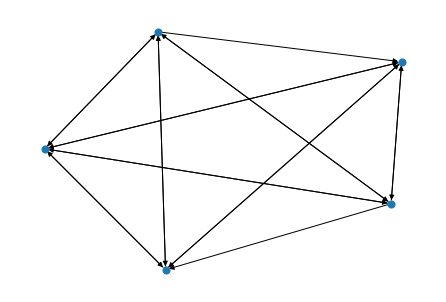

In [18]:
nx.draw(G, pos=nx.spring_layout(G), node_size=50)

In [19]:
gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
outmat

array([[0., 3., 2., 2., 1.],
       [0., 0., 3., 3., 2.],
       [0., 0., 0., 3., 2.],
       [0., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0.]])

Now generate a big graph and we'll start our performance analysis. Let's look at a serial version on a graph with 1000 nodes and about 5 outbound edges per node. 

Serial program to calculate mutual outlinks.

10081

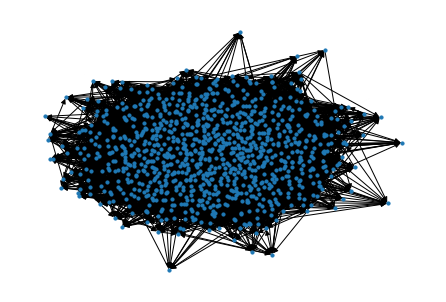

In [20]:
# cycles disappear when p = log(n)/n
G= nx.erdos_renyi_graph(1000,0.01,directed=True)
nx.draw(G, pos=nx.spring_layout(G), node_size=10)
G.number_of_edges()

In [21]:
import numpy as np

gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
        
np.count_nonzero(outmat)

48284

In [22]:
%%timeit
for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

3.96 s ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's a serial implementation. Let's parallelize it with `joblib`.

In [23]:
def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out
    
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(inner_loop)(i) for i in range(gmat.shape[0]))

outmat = np.array(partials)
np.count_nonzero(outmat)

48284

In [24]:
%%timeit
partials = Parallel(n_jobs=4)(delayed(inner_loop)(i) for i in range(gmat.shape[0]))

1.95 s ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK, this is where we stopped in Lecture 2.

#### Numba 

Numba is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code.  Let's look at the outcome of compiling the inner loop of our serial implementation. This should reduce the number of calls to the interpret to be O(rows) rather than O(row\*columns).

In [25]:
from numba import jit

outmat = np.zeros(gmat.shape)

@jit(nopython=True)
def comp_inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
    return partial_out
    
for i in range(gmat.shape[0]):
    outmat[i,:] = comp_inner_loop(i)

np.count_nonzero(outmat)

48284

In [26]:
%%timeit
for i in range(gmat.shape[0]):
    outmat[i,:] = comp_inner_loop(i)

101 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


OK, that is great. Let's try to compile the whole thing.

In [27]:
from numba import jit, prange

@jit(nopython=True)
def comp_inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
   # print(partial_out)
    return partial_out

# Gotta be in a function to compile
@jit(nopython=True)    
def comp_outerloop(outmat):

    for i in prange(gmat.shape[0]):
        outmat[i,:] = comp_inner_loop(i)


outmat = np.zeros(gmat.shape)
comp_outerloop(outmat)
np.count_nonzero(outmat)

48284

In [28]:
%%timeit
comp_outerloop(outmat)

98.9 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


OK that helped some. Not as much. I expect it's a tradeoff between having to move the matrix into the argument list. This is needed because global variables are read-only, i.e. if you try and write to a global outmat it is an error.

So, compiling the inner loop is powerful.  How about parallel?

In [29]:
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(comp_inner_loop)(i) for i in range(gmat.shape[0]))

outmat = np.array(partials)
np.count_nonzero(outmat)

48284

In [30]:
%%timeit
Parallel(n_jobs=4)(delayed(comp_inner_loop)(i) for i in range(gmat.shape[0]))

1.36 s ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That is **SLOWER**!!!  What happened?

The creation of the list is in Python and not compiled. So the creation of the delayed work takes longer than compiled code.

### Conclusions:

  * JIT Compilation is a powerful tool
  * JIT can only speed up the code that is compiled 
  * Parallelizing slow Python may not produce results as good as serial compiled.
 
Amdahl's law applies. Let's take a look at our performance results.


<AxesSubplot:>

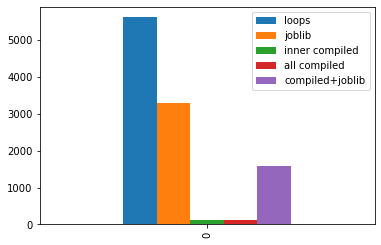

In [31]:
import pandas as pd

# get values from code
d = { 'loops': [5610], 'joblib': [3290], 'inner compiled': [132], 'all compiled': [122], 'compiled+joblib' : [1570] }

df = pd.DataFrame (data=d)
df.head()
df.plot.bar()

## Confusing

This material may not be self contained. Refer to the recorded lecture for comprehension.

### Reducing Interpreter Overhead

We are concerned about the overhead that comes from the interpretation process. One way to reduce this overhead is to run the same program while calling the interpreter fewer times.

Let's try to "flatten" the inner loop. Remove the for loop by iterating all combinations of `i, j`. This could reduce interpreter overhead. For loops in interpreted languages are slow.

In [15]:
def row_and_row (i,j):
  return np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

itertuples = list()

# define a generator function to enumerate all combinations of 2-rows
def gen_ij():
    for i in range(gmat.shape[0]):
        for j in range(i+1,gmat.shape[1]):
            yield (i,j)
    return
                
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(row_and_row)(i,j) for (i,j) in gen_ij())

outmat = np.array(partials)
np.count_nonzero(outmat)

46876

In [16]:
%%timeit
Parallel(n_jobs=4)(delayed(row_and_row)(i,j) for (i,j) in gen_ij())

2.92 s ± 34.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK this didn't seem to work. Slower. Probably owing to _startup costs_. This generates a list of length $i \times j$ and defines that many processes.  That's too much.

This is not a bad idea and flattening a loop works in many other circumstances.